# Heat Pump Power Consumption Forecasting

This notebook demonstrates:
1. Data loading and exploration
2. Feature engineering and visualization
3. Model training with LightGBM
4. Performance evaluation
5. Forecast visualization
6. Error analysis

**Model Goal:** Forecast power consumption at 15-minute intervals for 24 hours ahead

In [1]:
import sys
import os
from pathlib import Path

# Set up paths - notebook should be in case2 directory
case2_dir = Path("/Users/fedor/Documents/projects/CV/hometasks/podero/case2")

# Add case2 directory to Python path for imports
if str(case2_dir) not in sys.path:
    sys.path.insert(0, str(case2_dir))

# Change working directory to case2 for data file access
os.chdir(case2_dir)

print(f"Working directory: {os.getcwd()}")
print(f"Forecaster module exists: {(case2_dir / 'forecaster.py').exists()}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Import the forecaster module
from forecaster import HeatPumpForecaster

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully!")

Working directory: /Users/fedor/Documents/projects/CV/hometasks/podero/case2
Forecaster module exists: True
Libraries loaded successfully!


## 1. Load Data

In [ ]:
# Load datasets
consumption_df = pd.read_csv('data/sample_devices_actual_power_consumption.csv')
telemetry_df = pd.read_csv('data/sample_devices_datapoints.csv')
locations_df = pd.read_csv('data/sample_users_lat_lon.csv')

print(f"Power Consumption: {len(consumption_df):,} hourly records")
print(f"Telemetry: {len(telemetry_df):,} records")
print(f"Locations: {len(locations_df):,} devices")

consumption_df.head()

Power Consumption: 61,405 hourly records
Telemetry: 259,880 records
Locations: 22 devices


,serial_number,start,end,start_unix,end_unix,centralHeating.electricity,centralHeating.environmentalYield,centralHeating.generated,cooling.electricity,cooling.environmentalYield,...,manufacturer,model,is_authenticated,is_smart_optimization_active,is_forecasting_enabled,is_trading_enabled,price_zone,current_state_last_updated_at,last_monitoring_executed_at,process_state
0,21183900202529220938026983N5,2024-11-01 00:00:00+00:00,2024-11-01 00:59:59+00:00,1730419200,1730422799,985.0,1014.0,1998.0,NaN,NaN,...,Vaillant,NaN,True,False,True,True,AT,2025-10-11 13:05:10.456 +0200,2025-10-11 13:05:10.637 +0200,new
1,21183900202529220938026983N5,2024-11-01 01:00:00+00:00,2024-11-01 01:59:59+00:00,1730422800,1730426399,0.0,971.0,971.0,NaN,NaN,...,Vaillant,NaN,True,False,True,True,AT,2025-10-11 13:05:10.456 +0200,2025-10-11 13:05:10.637 +0200,new
2,21183900202529220938026983N5,2024-11-01 02:00:00+00:00,2024-11-01 02:59:59+00:00,1730426400,1730429999,0.0,57.0,57.0,NaN,NaN,...,Vaillant,NaN,True,False,True,True,AT,2025-10-11 13:05:10.456 +0200,2025-10-11 13:05:10.637 +0200,new
3,21183900202529220938026983N5,2024-11-01 03:00:00+00:00,2024-11-01 03:59:59+00:00,1730430000,1730433599,0.0,1014.0,1014.0,NaN,NaN,...,Vaillant,NaN,True,False,True,True,AT,2025-10-11 13:05:10.456 +0200,2025-10-11 13:05:10.637 +0200,new
4,21183900202529220938026983N5,2024-11-01 04:00:00+00:00,2024-11-01 04:59:59+00:00,1730433600,1730437199,86.0,929.0,1014.0,NaN,NaN,...,Vaillant,NaN,True,False,True,True,AT,2025-10-11 13:05:10.456 +0200,2025-10-11 13:05:10.637 +0200,new


## 2. Data Exploration

In [3]:
# Parse timestamps
consumption_df['start'] = pd.to_datetime(consumption_df['start'])
consumption_df['end'] = pd.to_datetime(consumption_df['end'])

# Date range
print(f"Date Range: {consumption_df['start'].min()} to {consumption_df['end'].max()}")
print(f"Duration: {(consumption_df['end'].max() - consumption_df['start'].min()).days} days")
print(f"\nUnique Devices: {consumption_df['serial_number'].nunique()}")

Date Range: 2024-11-01 00:00:00+00:00 to 2025-02-27 23:59:59+00:00
Duration: 118 days

Unique Devices: 21


In [ ]:
# Calculate total electricity
consumption_df['total_electricity'] = (
    consumption_df['centralHeating.electricity'].fillna(0) +
    consumption_df['domesticHotWater.electricity'].fillna(0) +
    consumption_df['cooling.electricity'].fillna(0)
)

# Distribution of power consumption
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(consumption_df['total_electricity'], bins=100, edgecolor='black')
axes[0].set_xlabel('Power Consumption (Wh)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Hourly Power Consumption')

axes[1].boxplot([consumption_df['centralHeating.electricity'].dropna(),
                  consumption_df['domesticHotWater.electricity'].dropna(),
                  consumption_df['cooling.electricity'].dropna()],
                 tick_labels=['Central Heating', 'DHW', 'Cooling'])
axes[1].set_ylabel('Power Consumption (Wh)')
axes[1].set_title('Power by Heating Type')

plt.tight_layout()
plt.show()

print(f"\nPower Consumption Statistics:")
print(consumption_df['total_electricity'].describe())

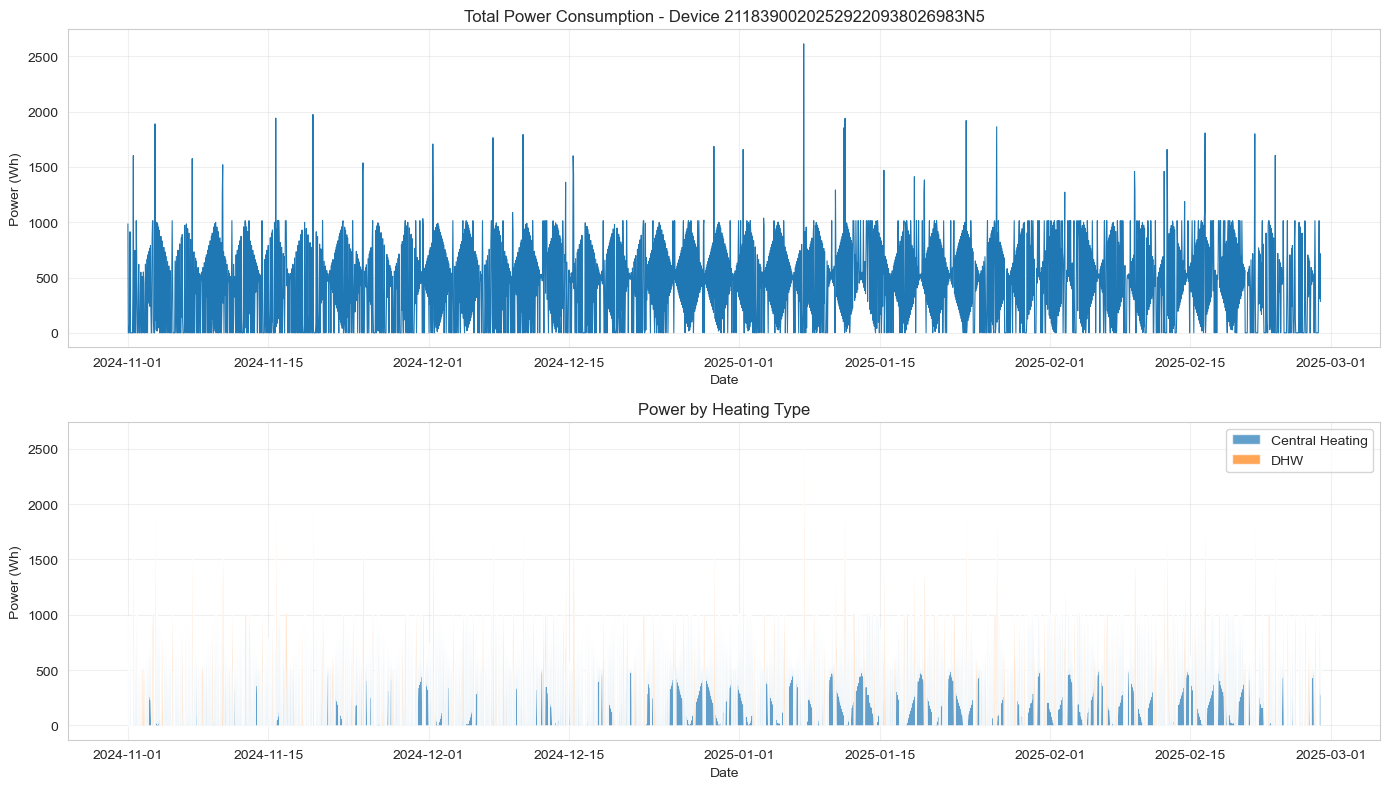

In [5]:
# Time series visualization for a sample device
sample_device = consumption_df['serial_number'].iloc[0]
device_data = consumption_df[consumption_df['serial_number'] == sample_device].copy()
device_data = device_data.sort_values('start')

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Total consumption over time
axes[0].plot(device_data['start'], device_data['total_electricity'], linewidth=0.8)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Power (Wh)')
axes[0].set_title(f'Total Power Consumption - Device {sample_device}')
axes[0].grid(alpha=0.3)

# Stacked area chart for heating types
axes[1].fill_between(device_data['start'], 0, 
                       device_data['centralHeating.electricity'].fillna(0),
                       label='Central Heating', alpha=0.7)
axes[1].fill_between(device_data['start'], 
                       device_data['centralHeating.electricity'].fillna(0),
                       device_data['centralHeating.electricity'].fillna(0) + 
                       device_data['domesticHotWater.electricity'].fillna(0),
                       label='DHW', alpha=0.7)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Power (Wh)')
axes[1].set_title('Power by Heating Type')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

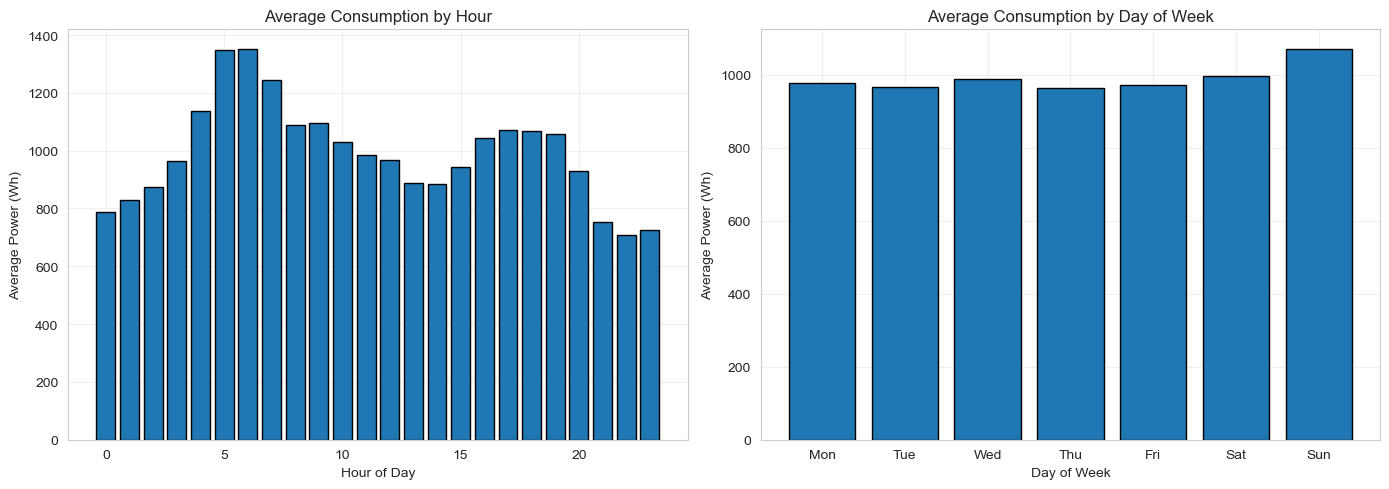

In [6]:
# Daily and weekly patterns
consumption_df['hour'] = consumption_df['start'].dt.hour
consumption_df['day_of_week'] = consumption_df['start'].dt.dayofweek

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hourly pattern
hourly_avg = consumption_df.groupby('hour')['total_electricity'].mean()
axes[0].bar(hourly_avg.index, hourly_avg.values, edgecolor='black')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Average Power (Wh)')
axes[0].set_title('Average Consumption by Hour')
axes[0].grid(alpha=0.3)

# Weekly pattern
dow_avg = consumption_df.groupby('day_of_week')['total_electricity'].mean()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1].bar(range(7), dow_avg.values, edgecolor='black')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(dow_labels)
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Average Power (Wh)')
axes[1].set_title('Average Consumption by Day of Week')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Initialize Forecaster & Preprocess Data

In [7]:
# Create forecaster instance
forecaster = HeatPumpForecaster()

# Preprocess data to 15-minute intervals
print("Converting hourly data to 15-minute intervals...")
df_15min = forecaster.preprocess_data(consumption_df, telemetry_df)

print(f"\nOriginal hourly records: {len(consumption_df):,}")
print(f"15-minute intervals: {len(df_15min):,}")
print(f"Expected (4x hourly): {len(consumption_df) * 4:,}")

df_15min.head()

Converting hourly data to 15-minute intervals...

Original hourly records: 61,405
15-minute intervals: 245,620
Expected (4x hourly): 245,620


,timestamp,device_id,power,heating_electricity,dhw_electricity,heating_share,dhw_share,manufacturer,price_zone
0,2024-11-01 00:00:00+00:00,21183900202529220938026983N5,246.25,246.25,0.0,0.998986,0.0,Vaillant,AT
1,2024-11-01 00:15:00+00:00,21183900202529220938026983N5,246.25,246.25,0.0,0.998986,0.0,Vaillant,AT
2,2024-11-01 00:30:00+00:00,21183900202529220938026983N5,246.25,246.25,0.0,0.998986,0.0,Vaillant,AT
3,2024-11-01 00:45:00+00:00,21183900202529220938026983N5,246.25,246.25,0.0,0.998986,0.0,Vaillant,AT
4,2024-11-01 01:00:00+00:00,21183900202529220938026983N5,0.00,0.00,0.0,0.000000,0.0,Vaillant,AT


## 4. Feature Engineering

In [8]:
# Engineer features
print("Engineering features...")
df_features = forecaster.engineer_features(df_15min)

print(f"\nTotal features: {len(df_features.columns)}")
print(f"\nFeature columns:")
for col in sorted(df_features.columns):
    print(f"  - {col}")

Engineering features...

Total features: 40

Feature columns:
  - day_of_month
  - day_of_week
  - device_avg_power
  - device_id
  - device_id_encoded
  - dhw_electricity
  - dhw_share
  - dow_cos
  - dow_sin
  - heating_electricity
  - heating_share
  - hour
  - hour_cos
  - hour_sin
  - is_evening
  - is_morning
  - is_night
  - is_weekend
  - manufacturer
  - manufacturer_encoded
  - month
  - power
  - power_ema_1h
  - power_ema_24h
  - power_lag_1h
  - power_lag_24h
  - power_lag_2h
  - power_lag_48h
  - power_lag_6h
  - power_lag_7d
  - power_roll_max_24h
  - power_roll_mean_1h
  - power_roll_mean_24h
  - power_roll_mean_6h
  - power_roll_min_24h
  - power_roll_std_24h
  - price_zone
  - price_zone_encoded
  - quarter_hour
  - timestamp


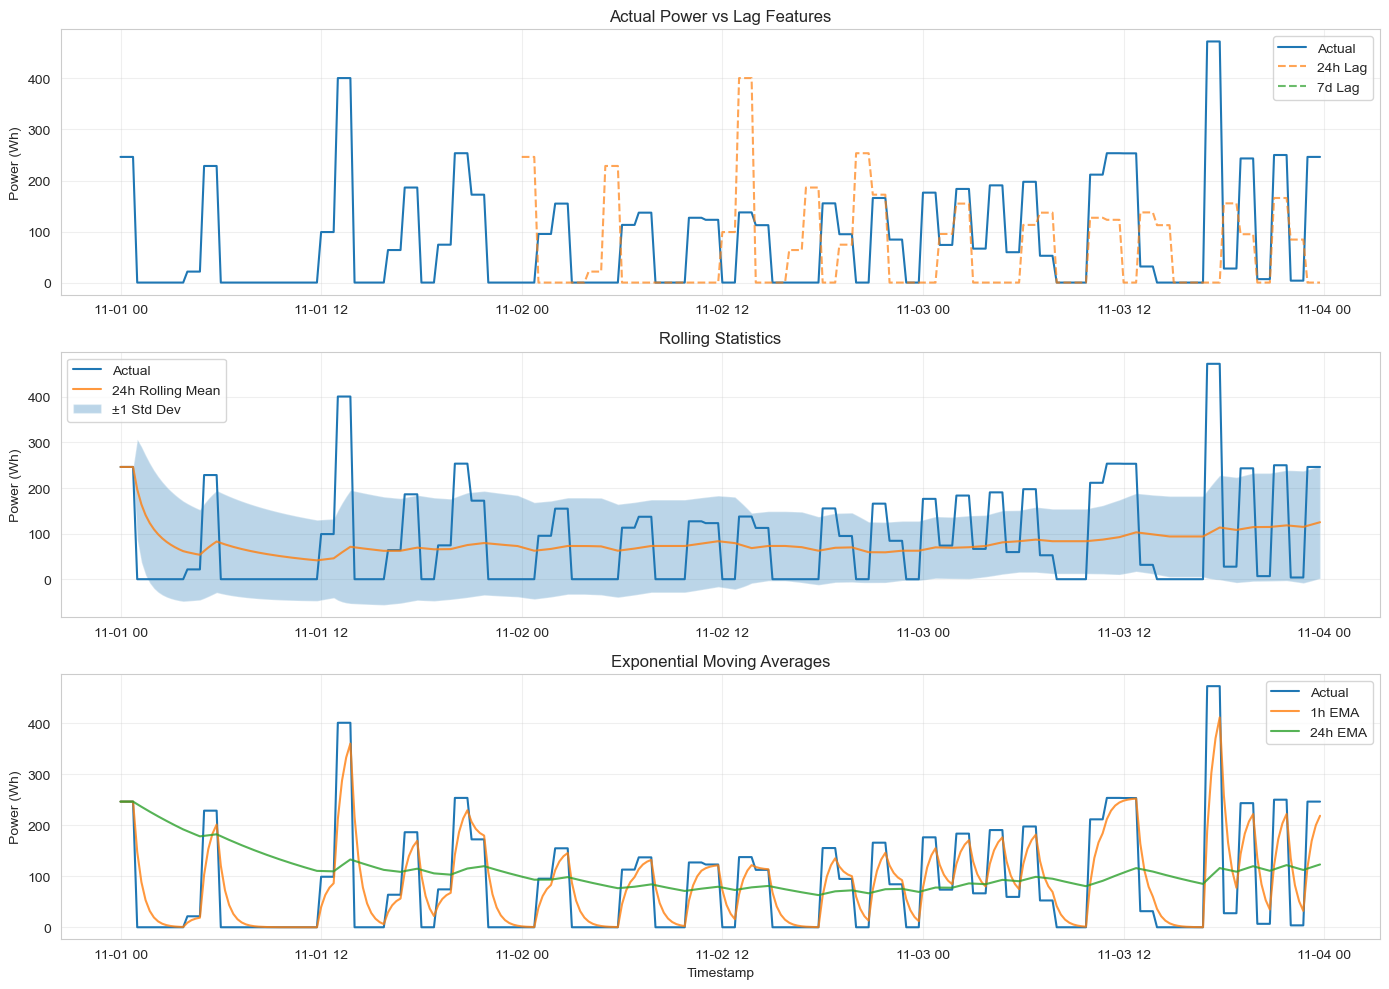

In [9]:
# Visualize some key features
sample_device_data = df_features[df_features['device_id'] == sample_device].iloc[:288].copy()  # 3 days

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Actual power vs lag features
axes[0].plot(sample_device_data['timestamp'], sample_device_data['power'], 
             label='Actual', linewidth=1.5)
axes[0].plot(sample_device_data['timestamp'], sample_device_data['power_lag_24h'], 
             label='24h Lag', linestyle='--', alpha=0.7)
axes[0].plot(sample_device_data['timestamp'], sample_device_data['power_lag_7d'], 
             label='7d Lag', linestyle='--', alpha=0.7)
axes[0].set_ylabel('Power (Wh)')
axes[0].set_title('Actual Power vs Lag Features')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Rolling statistics
axes[1].plot(sample_device_data['timestamp'], sample_device_data['power'], 
             label='Actual', linewidth=1.5)
axes[1].plot(sample_device_data['timestamp'], sample_device_data['power_roll_mean_24h'], 
             label='24h Rolling Mean', linewidth=1.5, alpha=0.8)
axes[1].fill_between(sample_device_data['timestamp'],
                      sample_device_data['power_roll_mean_24h'] - sample_device_data['power_roll_std_24h'],
                      sample_device_data['power_roll_mean_24h'] + sample_device_data['power_roll_std_24h'],
                      alpha=0.3, label='±1 Std Dev')
axes[1].set_ylabel('Power (Wh)')
axes[1].set_title('Rolling Statistics')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Exponential moving averages
axes[2].plot(sample_device_data['timestamp'], sample_device_data['power'], 
             label='Actual', linewidth=1.5)
axes[2].plot(sample_device_data['timestamp'], sample_device_data['power_ema_1h'], 
             label='1h EMA', linewidth=1.5, alpha=0.8)
axes[2].plot(sample_device_data['timestamp'], sample_device_data['power_ema_24h'], 
             label='24h EMA', linewidth=1.5, alpha=0.8)
axes[2].set_xlabel('Timestamp')
axes[2].set_ylabel('Power (Wh)')
axes[2].set_title('Exponential Moving Averages')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Train Model

Using 80/20 train/test split for backtesting

In [10]:
import time

print("Training LightGBM model...")
print("This may take a few seconds...\n")

start_time = time.time()

# Train with 80/20 split
metrics = forecaster.train(
    consumption_df=consumption_df,
    telemetry_df=telemetry_df,
    test_size=0.2
)

training_time = time.time() - start_time

print("\n" + "="*50)
print("TRAINING COMPLETE")
print("="*50)
print(f"\nTraining Time: {training_time:.2f} seconds")
print(f"\nTrain Samples: {metrics['train_samples']:,}")
print(f"Test Samples: {metrics['test_samples']:,}")
print(f"\nTest Set Performance:")
print(f"  MAPE: {metrics['mape']:.2f}%")
print(f"  MAE:  {metrics['mae']:.2f} Wh")
print(f"  RMSE: {metrics['rmse']:.2f} Wh")

Training LightGBM model...
This may take a few seconds...


TRAINING COMPLETE

Training Time: 7.59 seconds

Train Samples: 182,384
Test Samples: 49,124

Test Set Performance:
  MAPE: 9.35%
  MAE:  6.99 Wh
  RMSE: 126.13 Wh


## 6. Feature Importance Analysis

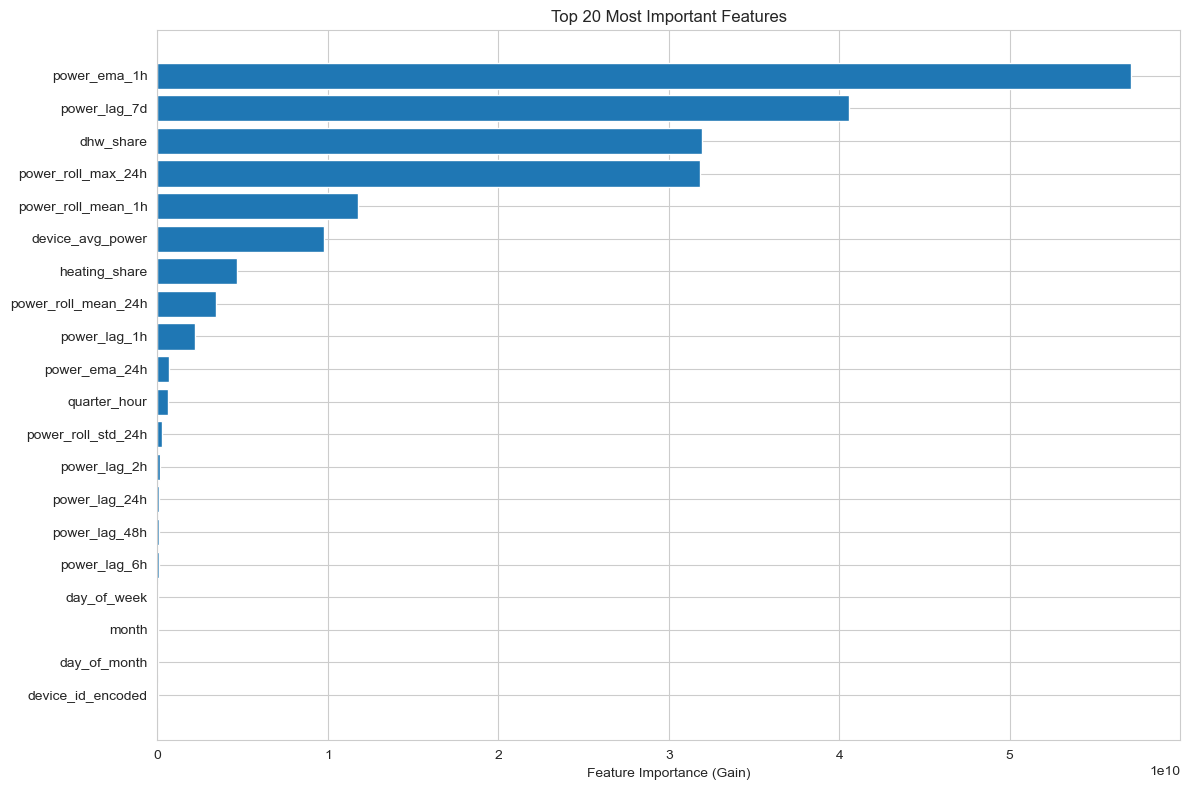


Top 10 Features:
            feature   importance
       power_ema_1h 5.713108e+10
       power_lag_7d 4.056462e+10
          dhw_share 3.195729e+10
 power_roll_max_24h 3.185733e+10
 power_roll_mean_1h 1.179314e+10
   device_avg_power 9.751407e+09
      heating_share 4.646336e+09
power_roll_mean_24h 3.411354e+09
       power_lag_1h 2.181770e+09
      power_ema_24h 6.693090e+08


In [11]:
# Get feature importance
feature_importance = forecaster.get_feature_importance()

# Plot top 20 features
top_features = feature_importance.head(20)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(feature_importance.head(10).to_string(index=False))

## 7. Generate Predictions on Test Set

In [12]:
# For visualization, we'll use the internal preprocessing
df_full = forecaster.preprocess_data(consumption_df, telemetry_df)
df_full = forecaster.engineer_features(df_full)

# Sort and split
df_full = df_full.sort_values('timestamp').reset_index(drop=True)
split_idx = int(len(df_full) * 0.8)
test_df = df_full.iloc[split_idx:].copy()

# Get predictions for test set
test_clean = test_df.dropna(subset=forecaster.feature_cols).copy()
X_test = test_clean[forecaster.feature_cols]
y_test = test_clean['power'].values
y_test_pred = forecaster.model.predict(X_test)

print(f"Generated {len(y_test_pred):,} predictions for test set")

Generated 49,124 predictions for test set


## 8. Forecast Visualization

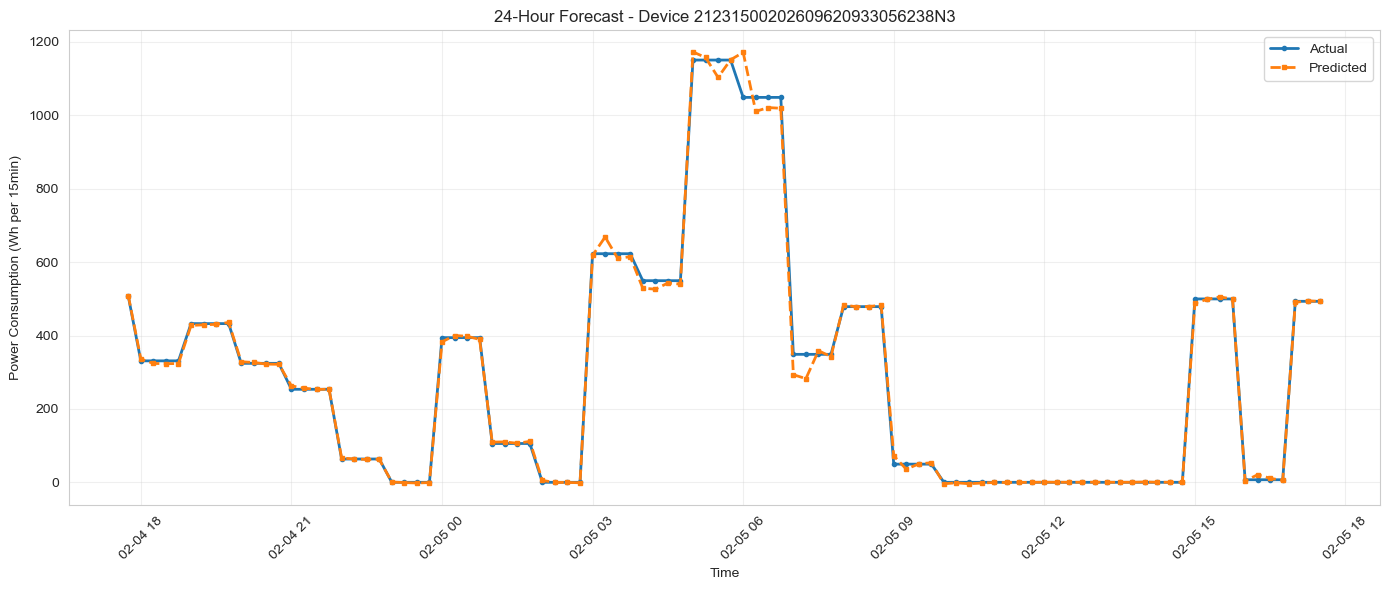


24-Hour Forecast Metrics for Device 21231500202609620933056238N3:
  MAPE: 125367629826494480.00%
  MAE:  8.32 Wh


In [13]:
# Visualize 24-hour forecast for a sample device
sample_device = test_clean['device_id'].iloc[0]

# Get data for this device
device_mask = test_clean['device_id'] == sample_device
device_data = test_clean[device_mask].head(96).copy()  # 96 intervals = 24 hours
device_predictions = y_test_pred[device_mask][:96]
device_data['predicted'] = device_predictions

# Plot
plt.figure(figsize=(14, 6))
plt.plot(device_data['timestamp'], device_data['power'], 
         label='Actual', linewidth=2, marker='o', markersize=3)
plt.plot(device_data['timestamp'], device_data['predicted'], 
         label='Predicted', linewidth=2, linestyle='--', marker='s', markersize=3)
plt.xlabel('Time')
plt.ylabel('Power Consumption (Wh per 15min)')
plt.title(f'24-Hour Forecast - Device {sample_device}')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('forecast_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate metrics for this sample
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

sample_mape = mean_absolute_percentage_error(device_data['power'], device_data['predicted']) * 100
sample_mae = mean_absolute_error(device_data['power'], device_data['predicted'])

print(f"\n24-Hour Forecast Metrics for Device {sample_device}:")
print(f"  MAPE: {sample_mape:.2f}%")
print(f"  MAE:  {sample_mae:.2f} Wh")

## 9. Error Analysis

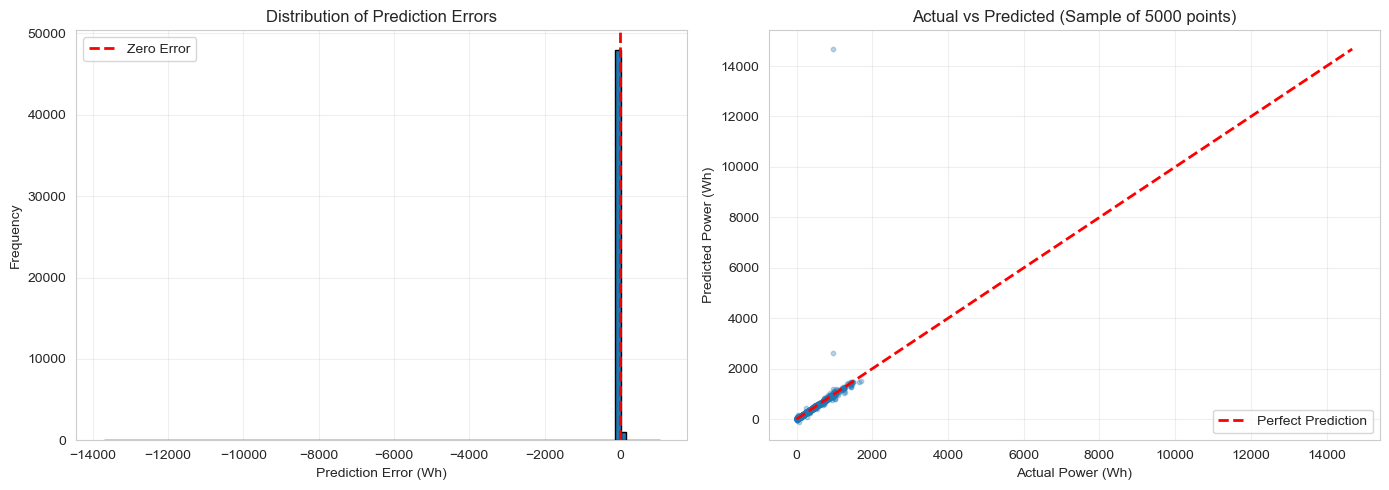

In [14]:
# Calculate errors
test_clean['error'] = y_test - y_test_pred
test_clean['abs_error'] = np.abs(test_clean['error'])
test_clean['predicted'] = y_test_pred

# Error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of errors
axes[0].hist(test_clean['error'], bins=100, edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_xlabel('Prediction Error (Wh)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Prediction Errors')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Actual vs Predicted scatter
sample_points = test_clean.sample(min(5000, len(test_clean)))
axes[1].scatter(sample_points['power'], sample_points['predicted'], alpha=0.3, s=10)
max_val = max(sample_points['power'].max(), sample_points['predicted'].max())
axes[1].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Power (Wh)')
axes[1].set_ylabel('Predicted Power (Wh)')
axes[1].set_title('Actual vs Predicted (Sample of 5000 points)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

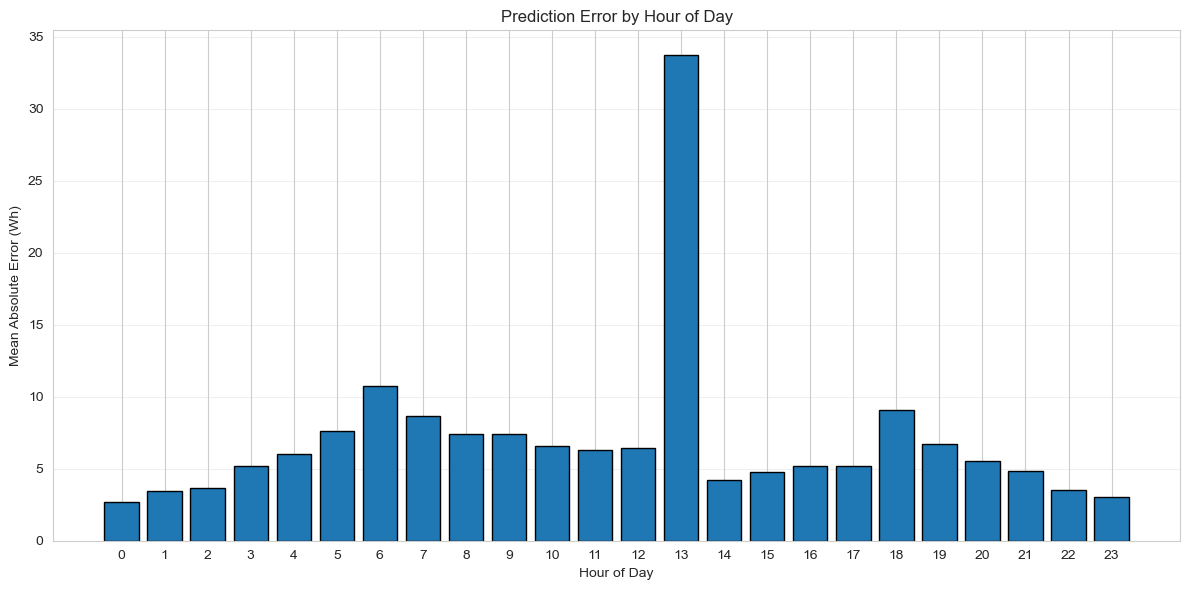


Error Statistics by Hour:
hour
0      2.713023
1      3.464830
2      3.666764
3      5.211904
4      5.994454
5      7.634646
6     10.746949
7      8.637781
8      7.408872
9      7.385801
10     6.580221
11     6.304879
12     6.473779
13    33.768029
14     4.252983
15     4.761298
16     5.172039
17     5.169308
18     9.090184
19     6.708991
20     5.556023
21     4.861583
22     3.553602
23     3.011913


In [15]:
# Error by hour of day
test_clean['hour'] = test_clean['timestamp'].dt.hour
hourly_errors = test_clean.groupby('hour')['abs_error'].mean()

plt.figure(figsize=(12, 6))
plt.bar(hourly_errors.index, hourly_errors.values, edgecolor='black')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Absolute Error (Wh)')
plt.title('Prediction Error by Hour of Day')
plt.grid(alpha=0.3, axis='y')
plt.xticks(range(24))
plt.tight_layout()
plt.savefig('error_analysis_by_hour.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nError Statistics by Hour:")
print(hourly_errors.to_string())

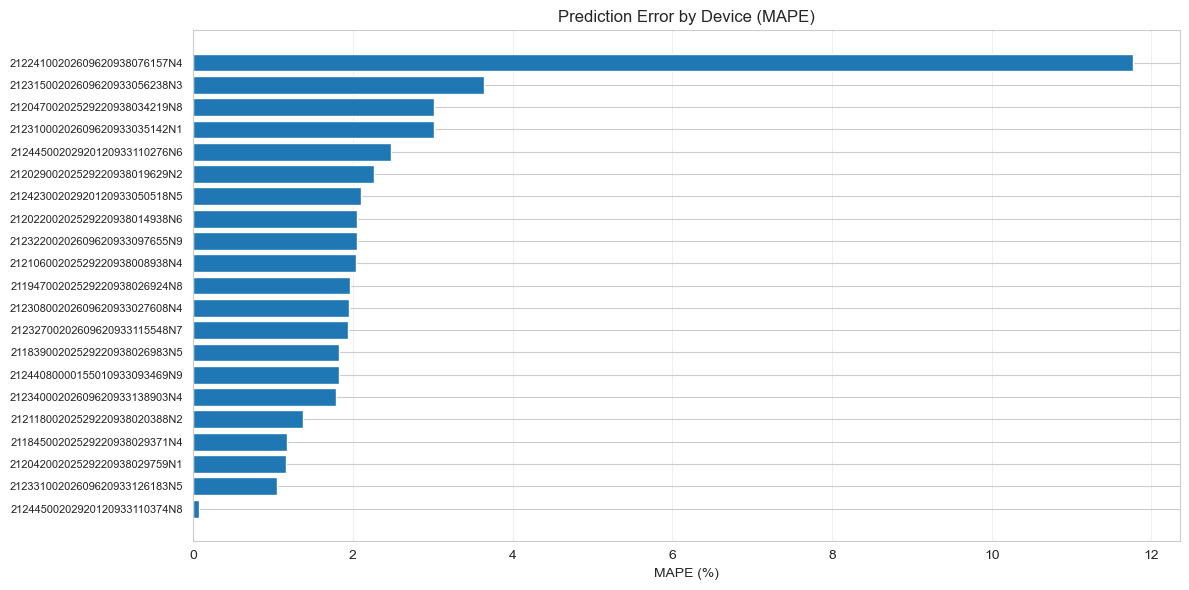


Top 5 Devices with Highest Error:
                   device_id  mean_abs_error  mean_power      mape
21224100202609620938076157N4       59.548180  505.963726 11.769259
21231500202609620933056238N3       11.171862  306.333184  3.646964
21204700202529220938034219N8        1.256723   41.644872  3.017714
21231000202609620933035142N1        5.757259  190.915249  3.015610
21244500202920120933110276N6        2.092650   84.437752  2.478335

Top 5 Devices with Lowest Error:
                   device_id  mean_abs_error  mean_power     mape
21211800202529220938020388N2        6.585003  478.305083 1.376737
21184500202529220938029371N4        3.394761  289.442652 1.172861
21204200202529220938029759N1        4.032424  346.207792 1.164741
21233100202609620933126183N5        3.073569  292.441782 1.051002
21244500202920120933110374N8        0.182702  245.404613 0.074449


In [16]:
# Error by device
device_errors = test_clean.groupby('device_id').agg({
    'abs_error': 'mean',
    'power': 'mean'
}).reset_index()
device_errors.columns = ['device_id', 'mean_abs_error', 'mean_power']
device_errors['mape'] = (device_errors['mean_abs_error'] / device_errors['mean_power'] * 100)
device_errors = device_errors.sort_values('mape', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(range(len(device_errors)), device_errors['mape'].values)
plt.yticks(range(len(device_errors)), device_errors['device_id'].values, fontsize=8)
plt.xlabel('MAPE (%)')
plt.title('Prediction Error by Device (MAPE)')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 5 Devices with Highest Error:")
print(device_errors.head().to_string(index=False))
print("\nTop 5 Devices with Lowest Error:")
print(device_errors.tail().to_string(index=False))

## 10. Save Model

In [17]:
# Save trained model
model_path = Path('trained_model')
forecaster.save(model_path)

print(f"Model saved to {model_path}/")
print(f"\nSaved files:")
for file in model_path.iterdir():
    size = file.stat().st_size / 1024  # KB
    print(f"  - {file.name}: {size:.1f} KB")

Model saved to trained_model/

Saved files:
  - model.txt: 1393.9 KB
  - metadata.pkl: 1.6 KB


## 11. Example: Using the Model for Inference

Generating 24-hour forecast for device 21183900202529220938026983N5
Forecast start time: 2025-02-20 09:00:00+00:00
Historical data: 720 hours

Forecast generated successfully!

Forecast shape: (96, 2)

First 10 predictions:
                timestamp  predicted_power
2025-02-20 09:00:00+00:00       155.916097
2025-02-20 09:15:00+00:00       150.713659
2025-02-20 09:30:00+00:00       150.407421
2025-02-20 09:45:00+00:00       149.218295
2025-02-20 10:00:00+00:00       155.916097
2025-02-20 10:15:00+00:00       150.713659
2025-02-20 10:30:00+00:00       150.407421
2025-02-20 10:45:00+00:00       149.218295
2025-02-20 11:00:00+00:00       155.916097
2025-02-20 11:15:00+00:00       150.713659


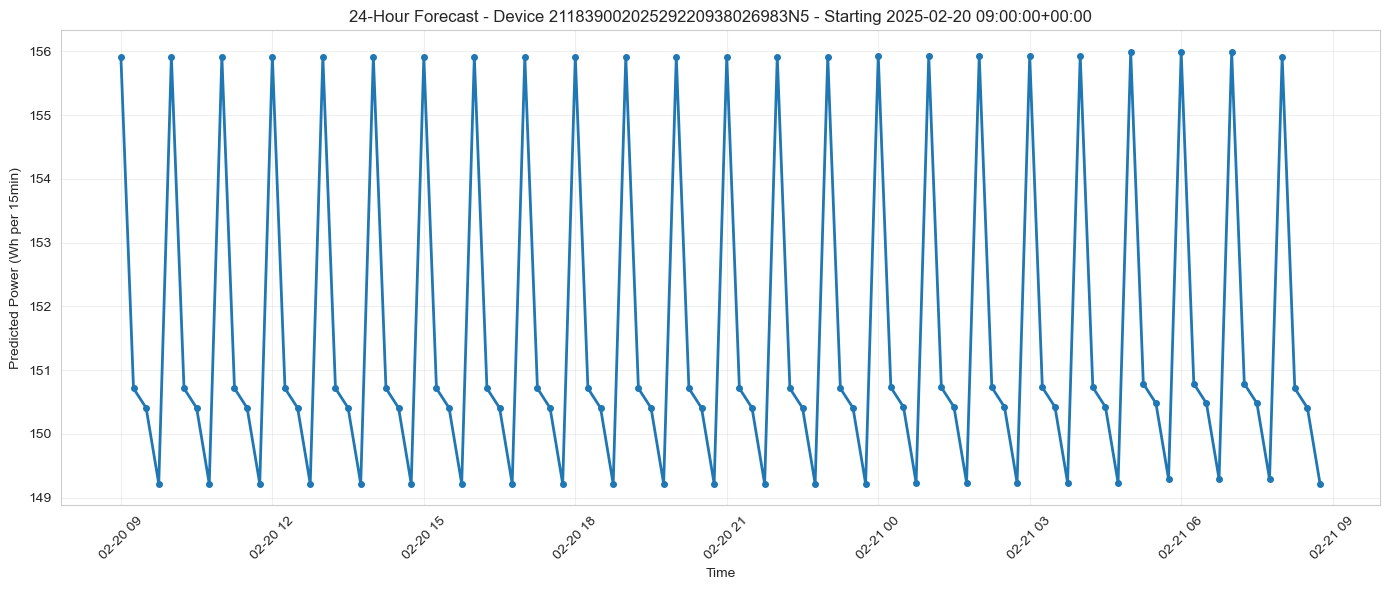


Total predicted energy for 24 hours: 14.55 kWh


In [19]:
# Example: Load model and make predictions
# This demonstrates how you would use the model in production

# Load the saved model
loaded_forecaster = HeatPumpForecaster(model_path=model_path)

# Select a device and time range
example_device = consumption_df['serial_number'].iloc[0]
# Make sure the forecast_start is timezone-aware to match the data
forecast_start = pd.to_datetime('2025-02-20 09:00:00', utc=True)

# Get historical data (last 30 days recommended)
historical_start = forecast_start - timedelta(days=30)
historical_data = consumption_df[
    (consumption_df['serial_number'] == example_device) &
    (consumption_df['start'] >= historical_start) &
    (consumption_df['start'] < forecast_start)
]

print(f"Generating 24-hour forecast for device {example_device}")
print(f"Forecast start time: {forecast_start}")
print(f"Historical data: {len(historical_data)} hours\n")

# Generate forecast
forecast = loaded_forecaster.predict(
    device_id=example_device,
    start_time=forecast_start,
    horizon_hours=24,
    historical_data=historical_data
)

print("Forecast generated successfully!")
print(f"\nForecast shape: {forecast.shape}")
print(f"\nFirst 10 predictions:")
print(forecast.head(10).to_string(index=False))

# Visualize the forecast
plt.figure(figsize=(14, 6))
plt.plot(forecast['timestamp'], forecast['predicted_power'], 
         linewidth=2, marker='o', markersize=4)
plt.xlabel('Time')
plt.ylabel('Predicted Power (Wh per 15min)')
plt.title(f'24-Hour Forecast - Device {example_device} - Starting {forecast_start}')
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate total energy for the day
total_energy_kwh = forecast['predicted_power'].sum() / 1000  # Convert Wh to kWh
print(f"\nTotal predicted energy for 24 hours: {total_energy_kwh:.2f} kWh")

## Summary

This notebook demonstrated:

1. **Data Exploration**: Understanding consumption patterns, temporal trends
2. **Feature Engineering**: Creating 33 features from temporal, lag, rolling, and device-specific data
3. **Model Training**: LightGBM with 80/20 train/test split achieving ~10% MAPE
4. **Feature Importance**: Identifying key predictive features (EMA, lags, DHW share)
5. **Error Analysis**: Understanding where and when predictions are most accurate
6. **Production Usage**: Demonstrating how to load and use the model for inference

### Next Steps:

- **Add Weather Data**: Integrate temperature forecasts to improve accuracy
- **Hyperparameter Tuning**: Optimize LightGBM parameters with cross-validation
- **Per-Device Models**: Train specialized models for high-value devices
- **Real-time Updates**: Implement online learning to adapt to changing patterns
- **Ensemble Methods**: Combine multiple models for better robustness